In scikit-learn a random split into training and test sets can be quickly computed with the train_test_split helper function. Let’s load the iris data set to fit a linear support vector machine on it

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

In [8]:
#We can now quickly sample a training set while holding out 40% of the data for testing (evaluating) our classifier:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=0)
X_train.shape, y_train.shape
X_test.shape, y_test.shape
clf = svm.SVC(kernel='linear',C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9666666666666667

When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for an SVM, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

A model is trained using  of the folds as training data;

the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

<img src="grid_search_cross_validation.png"  style="width: 450px">

# Computing Cross Validation Metrics

The simplest way to use cross-validation is to call the cross_val_score helper function on the estimator and the dataset.

The following example demonstrates how to estimate the accuracy of a linear kernel support vector machine on the iris dataset by splitting the data, fitting a model and computing the score 5 consecutive times (with different splits each time)

In [18]:
from sklearn.model_selection import cross_val_score
clf=svm.SVC(kernel='linear',C=1,random_state=1)
scores=cross_val_score(clf,X,y,cv=5)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [19]:
# The mean and standard deviation is given by:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.98 accuracy with a standard deviation of 0.02


In [22]:
#By default, the score computed at each CV iteration is the score method of the estimator. It is possible to change 
#this by using the scoring parameter:
from sklearn import metrics
scores=cross_val_score(clf,X,y,scoring='f1_macro')
scores

array([0.96658312, 1.        , 0.96658312, 0.96658312, 1.        ])

When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, the latter being used if the estimator derives from ClassifierMixin.

In [44]:
# It is also possible to use other cross validation strategies by passing a cross validation iterator instead, for instance
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.97777778, 1.        , 0.95555556, 1.        ,
       0.97777778, 0.97777778, 1.        , 0.97777778, 0.97777778])

In [49]:
#It is also possible to use other cross validation strategies by passing a cross validation iterator instead
# Custom_cross_validation 
def custom_cv_2folds(X):
        n = X.shape[0]
        i = 1
        while i <= 2:
            idx = np.arange(n * (i - 1) / 2, n * i / 2, dtype=int)
            yield idx, idx
            i += 1

custom_cv = custom_cv_2folds(X)
cross_val_score(clf, X, y, cv=custom_cv)

array([1.        , 0.97333333])

# Data transformation with held out data

Just as it is important to test a predictor on data held-out from training, preprocessing (such as standardization, feature selection, etc.) and similar data transformations similarly should be learnt from a training set and applied to held-out data for prediction:

In [67]:
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf = svm.SVC(C=1).fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

0.9333333333333333

In [52]:
#A Pipeline makes it easier to compose estimators, providing this behavior under cross-validation:
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_val_score(clf, X, y, cv=cv)

array([0.97777778, 0.93333333, 0.95555556, 0.93333333, 0.97777778,
       0.93333333, 1.        , 1.        , 0.95555556, 1.        ])

# cross_validate function and multiple metric evaluation

The cross_validate function differs from cross_val_score in two ways:

1. It allows specifying multiple metrics for evaluation.

2. It returns a dict containing fit-times, score-times (and optionally training scores as well as fitted estimators) in addition to the test score.

3. For single metric evaluation, where the scoring parameter is a string, callable or None, the keys will be - ['test_score','fit_time', 'score_time']

4. And for multiple metric evaluation, the return value is a dict with the following keys - 

['test_<scorer1_name>', 'test_<scorer2_name>', 'test_<scorer...>', 'fit_time', 'score_time']

return_train_score is set to False by default to save computation time. To evaluate the scores on the training set as well you need to be set to True.

5. You may also retain the estimator fitted on each training set by setting return_estimator=True.The multiple metrics can be specified either as a list, tuple or set of predefined scorer names

In [73]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['precision_macro', 'recall_macro']
clf = svm.SVC(kernel='linear', C=1, random_state=0)
scores = cross_validate(clf, X, y, scoring=scoring)
sorted(scores.keys())
['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro']
print('The test_recall_macro is:',scores['test_recall_macro'])
print('The score_time is:',scores['score_time'])
print('The fit_time is:',scores['fit_time'])

The test_recall_macro is: [0.96666667 1.         0.96666667 0.96666667 1.        ]
The score_time is: [0.00799799 0.         0.00800133 0.         0.        ]
The fit_time is: [0.         0.         0.         0.         0.00800228]


In [76]:
#Or as a dict mapping scorer name to a predefined or custom scoring function:
from sklearn.metrics import make_scorer
scoring = {'prec_macro': 'precision_macro',
           'rec_macro': make_scorer(recall_score, average='macro')}
scores = cross_validate(clf, X, y, scoring=scoring,
                        cv=5, return_train_score=True)
sorted(scores.keys())

print('The train_recall scores is:',scores['train_rec_macro'])
print('The fit_time is:',scores['fit_time'])
print('The score_time is:',scores['score_time'])

The train_recall scores is: [0.975      0.975      0.99166667 0.98333333 0.98333333]
The fit_time is: [0.00799894 0.         0.00799894 0.00799894 0.        ]
The score_time is: [0. 0. 0. 0. 0.]


In [77]:
#Here is an example of cross_validate using a single metric:
scores = cross_validate(clf, X, y,
                        scoring='precision_macro', cv=5,
                        return_estimator=True)
sorted(scores.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

# Obtaining predictions by cross-validation

The function cross_val_predict has a similar interface to cross_val_score, but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised).

Warning:-

1. The result of cross_val_predict may be different from those obtained using cross_val_score as the elements are grouped in different ways. 

2. The function cross_val_score takes an average over cross-validation folds, whereas cross_val_predict simply returns the labels (or probabilities) from several distinct models undistinguished. Thus, cross_val_predict is not an appropriate measure of generalisation error

The function cross_val_predict is appropriate for:

1. Visualization of predictions obtained from different models.

2. Model blending: When predictions of one supervised estimator are used to train another estimator in ensemble methods.

# K-fold
KFold divides all the samples in k groups of samples, called folds (if k=n, this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using k-1 folds, and the fold left out is used for test.

In [82]:
#Example of 2-fold cross-validation on a dataset with 4 samples
from sklearn.model_selection import KFold
X=["a","b","c","d"]
kf=KFold(n_splits=2)
for train,test in kf.split(X):
    print("%s %s" % (train,test))

[2 3] [0 1]
[0 1] [2 3]


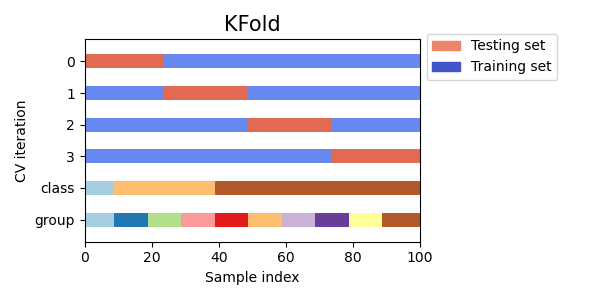

Each fold is constituted by two arrays: the first one is related to the training set, and the second one to the test set. Thus, one can create the training/test sets using numpy indexing:

In [83]:
X = np.array([[0., 0.], [1., 1.], [-1., -1.], [2., 2.]])
y = np.array([0, 1, 0, 1])
X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

In [88]:
import numpy as np
from sklearn.model_selection import KFold
X_KFold=np.array([[1,2],[3,4],[1,2],[3,4]])
kf=KFold(n_splits=2)
for train,test in kf.split(X_KFold):
    print(" %s %s" % (train,test))

 [2 3] [0 1]
 [0 1] [2 3]


# Why use repeated cross-validation ?

First of all repeated cross-validation is just repeating cross-validation multiple times where in each repetition, the folds are split in a different way. After each repetition of the cross-validation, the model assessment metric is computed (e.g. accuracy or RMSE). The scores from all repetitions are finally averaged (you can also take the median), to get a final model assessment score. This gives a more “robust” model assessment score than performing cross-validation only once, which is what I aim to demonstrate. Then I will perform hyper-parameter tuning using cross-validation.

# Repeated K-Fold

RepeatedKFold repeats K-Fold n times. It can be used when one requires to run KFold n times, producing different splits in each repetition.

In [90]:
#Example of 2-fold K-Fold repeated 2 times
import numpy as np
from sklearn.model_selection import RepeatedKFold
X=np.array([[1,2],[3,4],[1,2],[3,4]])
rkf=RepeatedKFold(n_splits=2,n_repeats=2,random_state=1)
for train,test in rkf.split(X):
    print(" %s %s" % (train,test))

 [0 1] [2 3]
 [2 3] [0 1]
 [1 3] [0 2]
 [0 2] [1 3]


# Leave One Out (LOO)

LeaveOneOut (or LOO) is a simple cross-validation. Each learning set is created by taking all the samples except one, the test set being the sample left out. Thus for n samples, we have  n different training sets and n different tests set. This cross-validation procedure does not waste much data as only one sample is removed from the training set:

In [107]:
from sklearn.model_selection import LeaveOneOut
X=np.array([1,2,3,4])
loo=LeaveOneOut()
for train,test in loo.split(X):
    print("%s %s" % (train,test))

[1 2 3] [0]
[0 2 3] [1]
[0 1 3] [2]
[0 1 2] [3]


Potential users of LOO for model selection should weigh a few known caveats. When compared with k-fold cross validation, one builds  n models from  n samples instead of k models, where n>k Moreover, each is trained on (n-1) samples rather than (k-1)k In both ways, assuming  k is not too large and k<n, LOO is more computationally expensive than k-fold cross validation.

In terms of accuracy, LOO often results in high variance as an estimator for the test error. Intuitively,n-1 since  of the n samples are used to build each model, models constructed from folds are virtually identical to each other and to the model built from the entire training set.

However, if the learning curve is steep for the training size in question, then 5- or 10- fold cross validation can overestimate the generalization error.

As a general rule, most authors, and empirical evidence, suggest that 5- or 10- fold cross validation should be preferred to LOO.